In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV

# 최대 재귀함수 깊이 설정
import sys
sys.setrecursionlimit(10**7)

# timedelta import
from datetime import timedelta

# datetime import
from datetime import datetime


In [38]:
df= pd.read_csv('data/price/price_baechoo.csv')
# df 구분 인덱스로 설정
df.set_index('구분', inplace=True)

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)

df

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [39]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df_train = df.loc['2000':'2022-11']
df_test = df.loc['2022-11':'2022-12']

In [40]:
df_test

,가격
구분,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


In [132]:
df_train

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-10-25,8172.0
2022-10-26,8072.0
2022-10-27,8252.0


연속적으로 5개 층이 밀리는 방식

In [133]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가','종가','날짜'])

# 연속적으로 5일간의 데이터를 하나의 데이터로 만들기 위한 함수 index 1 is out of bounds for axis 0 with size 1
def make_candle(df, candle_df):
    for i in range(len(df)-4):
        candle_df.loc[i, '시가'] = df.iloc[i, 0]
        candle_df.loc[i, '고가'] = max(df.iloc[i, 0], df.iloc[i+1, 0], df.iloc[i+2, 0], df.iloc[i+3, 0], df.iloc[i+4, 0])
        candle_df.loc[i, '저가'] = min(df.iloc[i, 0], df.iloc[i+1, 0], df.iloc[i+2, 0], df.iloc[i+3, 0], df.iloc[i+4, 0])
        candle_df.loc[i, '종가'] = df.iloc[i+4, 0]
        candle_df.loc[i, '날짜'] = df.index[i+4]
    return candle_df

candle_df = make_candle(df_train, candle_df)

# 날짜 컬럼을 인덱스로 설정
candle_df.set_index('날짜', inplace=True)

# shift "종가_shift" 컬럼 생성
candle_df['종가_shift'] = candle_df['종가'].shift(-1)

# copy 
candle_df_all = candle_df.copy()

# 결측치 제거
candle_df.dropna(inplace=True)

candle_df

,시가,고가,저가,종가,종가_shift
날짜,,,,,
2000-01-07,5600.0,5700.0,5600.0,5670.0,5770.0
2000-01-08,5600.0,5770.0,5600.0,5770.0,5790.0
2000-01-10,5620.0,5790.0,5620.0,5790.0,5740.0
2000-01-11,5700.0,5790.0,5670.0,5740.0,5630.0
2000-01-12,5670.0,5790.0,5630.0,5630.0,5630.0
...,...,...,...,...,...
2022-10-24,9706.0,9706.0,8583.0,8663.0,8172.0
2022-10-25,9193.0,9193.0,8172.0,8172.0,8072.0
2022-10-26,9043.0,9043.0,8072.0,8072.0,8252.0


/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.draw()
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.draw()
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from current font.
  fig.canvas.draw()
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:title={'center':'Person Correlation of Features'}>

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/IPython/core/pylabtools.p

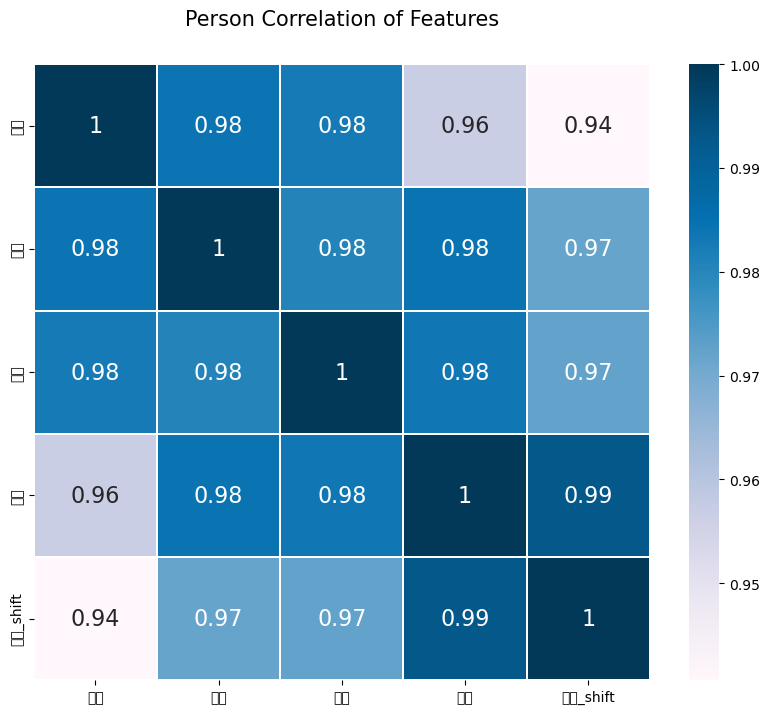

In [143]:
import seaborn as sns

heatmap_data= candle_df[['시가', '고가', '저가', '종가', '종가_shift']]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [43]:
feature= candle_df[['시가', '고가', '저가','종가']]
target= candle_df[['종가_shift']]

# feature, target 데이터 스케일링
scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

In [44]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (4684, 4) (4684, 1)
테스트 데이터의 크기 : (1171, 4) (1171, 1)


In [45]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(train_X, train_y)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.01, 'subsample': 1}
최고 예측 정확도: 0.9804


In [46]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(train_X, train_y)

# XGBoost 모델을 평가한다
y_pred = xgb.predict(test_X)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(test_y, y_pred)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(test_y, y_pred))


XGBoost 모델의 RMSE: 0.032686087680668774
XGBoost 모델의 r2_score: 0.9520299499478262


In [47]:
# 모델 저장
pickle.dump(xgb, open('model/xgb_model_s2s.pkl', 'wb'))

# scaler 저장
pickle.dump(scaler1, open('model/scaler1.pkl', 'wb'))
pickle.dump(scaler2, open('model/scaler2.pkl', 'wb'))


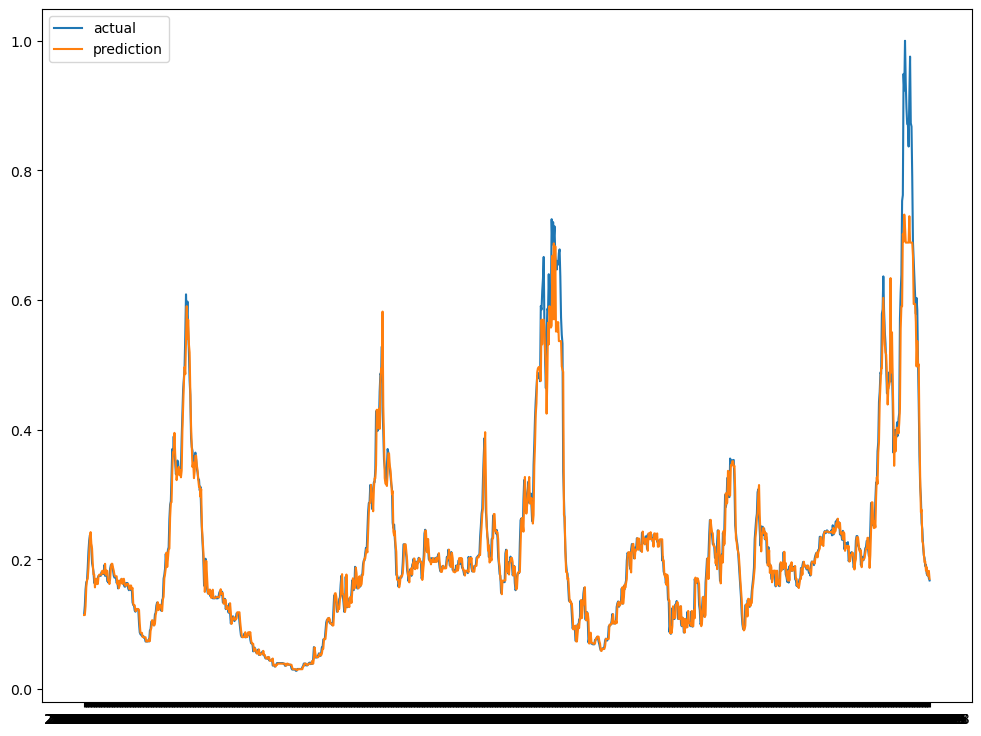

In [48]:
# 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_y, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()




Make new data

In [49]:
candle_df_all

,시가,고가,저가,종가,종가_shift
날짜,,,,,
2000-01-07,5600.0,5700.0,5600.0,5670.0,5770.0
2000-01-08,5600.0,5770.0,5600.0,5770.0,5790.0
2000-01-10,5620.0,5790.0,5620.0,5790.0,5740.0
2000-01-11,5700.0,5790.0,5670.0,5740.0,5630.0
2000-01-12,5670.0,5790.0,5630.0,5630.0,5630.0
...,...,...,...,...,...
2022-10-25,9193.0,9193.0,8172.0,8172.0,8072.0
2022-10-26,9043.0,9043.0,8072.0,8072.0,8252.0
2022-10-27,8583.0,8663.0,8072.0,8252.0,7916.0


In [50]:
test_data = pd.DataFrame(columns=['시가', '고가', '저가','종가'])

# "시가"= 8172.0, "고가"= 8252.0, "저가"= 7792.5, "종가"= 7792.5
test_data.loc[0] = [8172.0, 8252.0, 7792.5, 7792.5]

test_data

,시가,고가,저가,종가
0,8172.0,8252.0,7792.5,7792.5


In [51]:
model = pickle.load(open('model/xgb_model_s2s.pkl', 'rb'))
scaler1 = pickle.load(open('model/scaler1.pkl', 'rb'))
scaler2 = pickle.load(open('model/scaler2.pkl', 'rb'))

# model predict using test_data
test_data_sc = scaler1.transform(test_data)
test_data_sc = pd.DataFrame(test_data_sc, columns=test_data.columns, index=test_data.index)
y_pred = model.predict(test_data_sc)
# reshape
y_pred = y_pred.reshape(-1, 1)
# inverse transform
y_pred = scaler2.inverse_transform(y_pred)
y_pred
# 10월 31일 
# 11월 1일 실제 가격 7350.0

array([[7879.4243]], dtype=float32)

In [52]:
y_pred[0]

array([7879.4243], dtype=float32)

In [53]:
new= df_train.tail(5)

# df_test 인덱스를 가져온다
index = df_test.index

# df_test copy
df_test_copy = df_test.copy()

# dataframe을 만든다 컬럼 
df_test_copy = pd.DataFrame(columns=['가격'], index=index)
df_test_copy = pd.concat([df_test_copy, new], axis=0).sort_index()

# df_test_copy date index를 datetime으로 변환
df_test_copy.index = pd.to_datetime(df_test_copy.index)
df_test_copy

,가격
구분,
2022-10-25,8172.0
2022-10-26,8072.0
2022-10-27,8252.0
2022-10-28,7916.0
2022-10-31,7792.5
2022-11-01,NaN
2022-11-02,NaN
2022-11-03,NaN
2022-11-04,NaN


In [61]:
new_test= df_train.tail(5)

# df_test 인덱스를 가져온다
index = df_test.index

# df_test copy
df_test_copy_test = df_test.copy()

# dataframe을 만든다 컬럼 
df_test_copy_test = pd.DataFrame(columns=['가격'], index=index)
df_test_copy_test = pd.concat([df_test_copy_test, new_test], axis=0).sort_index()

# df_test_copy_test date index를 datetime으로 변환
df_test_copy_test.index = pd.to_datetime(df_test_copy_test.index)

df_test_copy_test= df_test_copy_test.reset_index()
df_test_copy_test

,구분,가격
0,2022-10-25,8172.0
1,2022-10-26,8072.0
2,2022-10-27,8252.0
3,2022-10-28,7916.0
4,2022-10-31,7792.5
5,2022-11-01,NaN
6,2022-11-02,NaN
7,2022-11-03,NaN
8,2022-11-04,NaN
9,2022-11-07,NaN


In [128]:
test_data= pd.DataFrame(columns=['시가', '고가', '저가', '종가'])
test_data.loc[0] = [8172.0, 8252.0, 7792.5, 7792.5]
test_data.loc[1]= [8072, 8252, 7792.5, 5000.4243]



# model predict using test_data
test_data_sc = scaler1.transform(test_data)
test_data_sc = pd.DataFrame(test_data_sc, columns=test_data.columns, index=test_data.index)
y_pred = model.predict(test_data_sc)
# reshape
y_pred = y_pred.reshape(-1, 1)
# inverse transform
y_pred = scaler2.inverse_transform(y_pred)
y_pred

array([[7879.4243],
       [4784.937 ]], dtype=float32)

In [118]:
candle_test= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '종가_shift'])

candle_test.loc[0, '시가'] = df_test_copy_test.loc[0, '가격']
candle_test.loc[0, '고가'] = df_test_copy_test.loc[0:4, '가격'].max()
candle_test.loc[0, '저가'] = df_test_copy_test.loc[0:4, '가격'].min()
candle_test.loc[0, '종가'] = df_test_copy_test.loc[4, '가격']


candle_test_data= candle_test.iloc[0][['시가', '고가', '저가', '종가']]
# print(candle_test_data)
# candle_test_data reshape
candle_test_data = candle_test_data.values.reshape(1, -1)
new_candle_test_sc = scaler1.transform(candle_test_data)
new_candle_test_sc = pd.DataFrame(new_candle_test_sc, columns=['시가', '고가', '저가', '종가'])
print(new_candle_test_sc)

# # float64로 변환
# new_candle_test = new_candle_test.astype('float64')
y_pred = model.predict(new_candle_test_sc)
# # reshape
y_pred = y_pred.reshape(-1, 1)
# # inverse transform
y_pred = scaler2.inverse_transform(y_pred)
print(y_pred)
# y_pred
candle_test.loc[0]['종가_shift'] = y_pred[0][0]
df_test_copy_test.loc[5, '가격']= y_pred[0][0]

candle_test.loc[1, '시가'] = df_test_copy_test.loc[1, '가격']
candle_test.loc[1, '고가'] = df_test_copy_test.loc[1:5, '가격'].max()
candle_test.loc[1, '저가'] = df_test_copy_test.loc[1:5, '가격'].min()
candle_test.loc[1, '종가'] = df_test_copy_test.loc[5, '가격']

candle_test_data= candle_test.iloc[1][['시가', '고가', '저가', '종가']]
# print(candle_test_data)
# candle_test_data reshape
candle_test_data = candle_test_data.values.reshape(1, -1)
new_candle_test_sc = scaler1.transform(candle_test_data)
new_candle_test_sc = pd.DataFrame(new_candle_test_sc, columns=['시가', '고가', '저가', '종가'])
print(new_candle_test_sc)

# # float64로 변환
# new_candle_test = new_candle_test.astype('float64')
y_pred = model.predict(new_candle_test_sc)
# # reshape
y_pred = y_pred.reshape(-1, 1)
# # inverse transform
y_pred = scaler2.inverse_transform(y_pred)
print(y_pred)
# y_pred
candle_test.loc[1]['종가_shift'] = y_pred[0][0]
df_test_copy_test.loc[6, '가격']= y_pred[0][0]


         시가        고가        저가        종가
0  0.178141  0.179678  0.186959  0.167614
[[7879.4243]]
         시가        고가        저가        종가
0  0.175368  0.179678  0.186959  0.170026
[[7879.4243]]


/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [116]:
candle_test

,시가,고가,저가,종가,종가_shift
0,8172.0,8252.0,7792.5,7792.5,7879.424316
1,8072.0,8252.0,7792.5,7879.424316,7879.424316


In [121]:

# 위의 코드를 함수로 만들어서 반복문으로 돌리기
for i in range(2, 30):
    candle_test.loc[i, '시가'] = df_test_copy_test.loc[i, '가격']
    candle_test.loc[i, '고가'] = df_test_copy_test.loc[i:i+4, '가격'].max()
    candle_test.loc[i, '저가'] = df_test_copy_test.loc[i:i+4, '가격'].min()
    candle_test.loc[i, '종가'] = df_test_copy_test.loc[i+4, '가격']

    candle_test_data= candle_test.iloc[i][['시가', '고가', '저가', '종가']]
    # print(candle_test_data)
    # candle_test_data reshape
    candle_test_data = candle_test_data.values.reshape(1, -1)
    new_candle_test_sc = scaler1.transform(candle_test_data)
    new_candle_test_sc = pd.DataFrame(new_candle_test_sc, columns=['시가', '고가', '저가', '종가'])
    print(new_candle_test_sc)

    # # float64로 변환
    # new_candle_test = new_candle_test.astype('float64')
    y_pred = model.predict(new_candle_test_sc)
    # # reshape
    y_pred = y_pred.reshape(-1, 1)
    # # inverse transform
    y_pred = scaler2.inverse_transform(y_pred)
    print(y_pred)
    # y_pred
    candle_test.loc[i]['종가_shift'] = y_pred[0][0]
    df_test_copy_test.loc[i+5, '가격']= y_pred[0][0]


/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

         시가        고가        저가        종가
0  0.180361  0.179678  0.186959  0.170026
[[7879.4243]]
        시가       고가        저가        종가
0  0.17104  0.17035  0.186959  0.170026
[[7879.4243]]
         시가        고가        저가        종가
0  0.167614  0.169334  0.186959  0.170026
[[7887.778]]
         시가        고가        저가        종가
0  0.170026  0.169566  0.189648  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170026  0.169566  0.189648  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170026  0.169566  0.189648  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170026  0.169566  0.189648  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가 

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가      

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가      

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가      

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가        고가        저가        종가
0  0.170257  0.169566  0.189906  0.170257
[[7887.778]]
         시가      

/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/bagjeonghyeon/miniforge3/envs/baseDeep/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler wa

In [125]:
# df_test_copy_test(head 10)
df_test_copy_test.head(30)

,구분,가격
0,2022-10-25,8172.000000
1,2022-10-26,8072.000000
2,2022-10-27,8252.000000
3,2022-10-28,7916.000000
4,2022-10-31,7792.500000
5,2022-11-01,7879.424316
6,2022-11-02,7879.424316
7,2022-11-03,7879.424316
8,2022-11-04,7879.424316
9,2022-11-07,7887.777832
